**Experiment 1: Class Fine Tuning**

The motivation of this experiment is to confirm that focusing the fine-tuning process on the breeds of interest will  boost the accuracy.

> WITHOUT class fine tuning: fine tune on all 120 breeds

> WITH class fine tuning: fine tune on only the 25 breeds of interest





In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Exploring Dataset 

Change the following to match your directory set up:

`data_dir`: the directory of the Stanford Dataset

`test_dir`: the directory of the Wyze Dataset (test dataset)

In [ ]:
data_dir = '/content/drive/MyDrive/ENGINE: Wyze/Images/stanfordImages/'
test_dir = '/content/drive/MyDrive/ENGINE: Wyze/Images/stdogs25/'

# Define train and test path 
train_path = os.path.join(data_dir, 'Images') #train
test_path = os.path.join(test_dir, 'wyze')    #test

In [ ]:
train_dataset = ImageFolder(train_path)
test_dataset = ImageFolder(test_path)
print(train_dataset)
print(test_dataset)

# Train
train_size = len(train_dataset)
train_classes = len(train_dataset.classes)
print("Number of dataset images:", train_size)
print("Number of class:", train_classes)

# Test
test_size = len(test_dataset)
test_classes = len(test_dataset.classes)
print("Number of dataset images:", test_size)
print("Number of class:", test_classes)

Dataset ImageFolder
    Number of datapoints: 20580
    Root location: /content/drive/MyDrive/ENGINE: Wyze/Images/stanfordImages/Images
Dataset ImageFolder
    Number of datapoints: 829
    Root location: /content/drive/MyDrive/ENGINE: Wyze/Images/stdogs25/wyze
Number of dataset images: 20580
Number of class: 120
Number of dataset images: 829
Number of class: 25


In [ ]:
print(len(train_dataset.imgs))
print(len(test_dataset.imgs))

20580
829


In [ ]:
dogs_dict = train_dataset.class_to_idx
print(dogs_dict)
print("Num of classes", len((train_dataset.class_to_idx)))

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

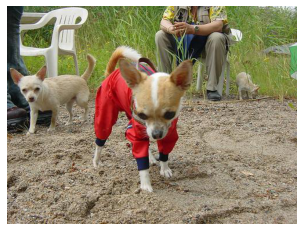

In [ ]:
plt.imshow(train_dataset[10][0])
plt.axis('off')
plt.show()

In [ ]:
dog_labels_train = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in train_dataset.classes:
    dog_labels_train.append(rename(n))

In [ ]:
dog_labels_train

['Chihuahua',
 'Japanese spaniel',
 'Maltese dog',
 'Pekinese',
 'Shih Tzu',
 'Blenheim spaniel',
 'papillon',
 'toy terrier',
 'Rhodesian ridgeback',
 'Afghan hound',
 'basset',
 'beagle',
 'bloodhound',
 'bluetick',
 'black and tan coonhound',
 'Walker hound',
 'English foxhound',
 'redbone',
 'borzoi',
 'Irish wolfhound',
 'Italian greyhound',
 'whippet',
 'Ibizan hound',
 'Norwegian elkhound',
 'otterhound',
 'Saluki',
 'Scottish deerhound',
 'Weimaraner',
 'Staffordshire bullterrier',
 'American Staffordshire terrier',
 'Bedlington terrier',
 'Border terrier',
 'Kerry blue terrier',
 'Irish terrier',
 'Norfolk terrier',
 'Norwich terrier',
 'Yorkshire terrier',
 'wire haired fox terrier',
 'Lakeland terrier',
 'Sealyham terrier',
 'Airedale',
 'cairn',
 'Australian terrier',
 'Dandie Dinmont',
 'Boston bull',
 'miniature schnauzer',
 'giant schnauzer',
 'standard schnauzer',
 'Scotch terrier',
 'Tibetan terrier',
 'silky terrier',
 'soft coated wheaten terrier',
 'West Highland wh

#Creating training, validation, and testing dataset from Stanford Dog Dataset



 

In [ ]:
# 10% of Stanford used for validation, 90% of Stanford used for training
# use wyze dataset for testing
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 20580
    Root location: /content/drive/MyDrive/ENGINE: Wyze/Images/stanfordImages/Images
Dataset ImageFolder
    Number of datapoints: 829
    Root location: /content/drive/MyDrive/ENGINE: Wyze/Images/stdogs25/wyze


In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

In [ ]:
# Splitting Stanford DogDataset into Train, Val, Test
dataset_size = len(train_dataset)
test_size = 0

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_size, val_size, test_size

(18522, 2058, 0)

In [ ]:
train_ds1, val_ds1, test_ds0 = random_split(train_dataset, [train_size, val_size, test_size])
train_ds0, val_ds0, test_ds1 = random_split(test_dataset, [0, 0, 829])

len(train_ds1), len(val_ds1), len(test_ds1)

(18522, 2058, 829)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


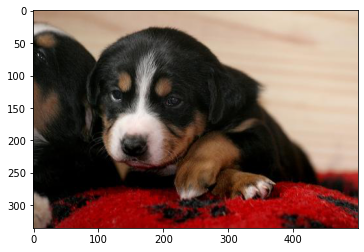

In [ ]:
img, label = train_ds1[6]
print(train_dataset.classes[label])
plt.imshow(img)
print(type(img))

n02087046-toy_terrier
<class 'PIL.Image.Image'>


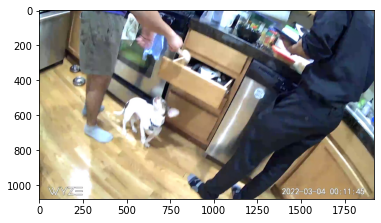

In [ ]:
img, label = test_ds1[6]
print(test_dataset.classes[label])
plt.imshow(img)
print(type(img))

#Creating Custom Dataset

In [ ]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=30),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)), 
    transforms.ToTensor()
])

In [ ]:
train_dataset = DogBreedDataset(train_ds1, test_transform)
val_dataset = DogBreedDataset(val_ds1, test_transform)
test_dataset = DogBreedDataset(test_ds1, test_transform)

89


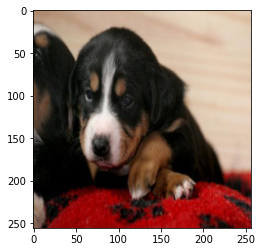

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

65


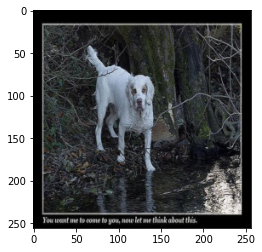

In [ ]:
img, label = val_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

2


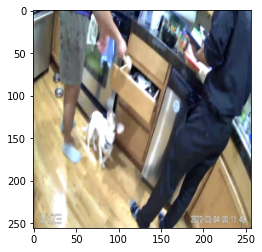

In [ ]:
img, label = test_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [ ]:
# Uncomment below to show a sample of data batch
# show_batch(train_dl)

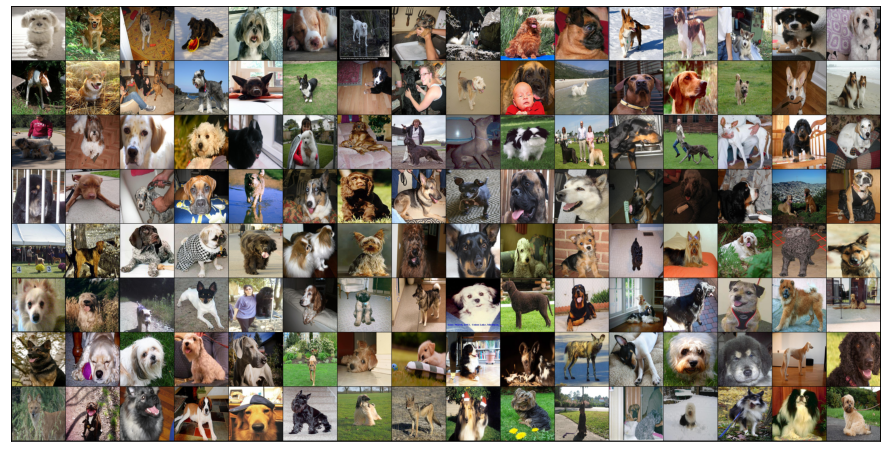

In [ ]:
# show_batch(val_dl)

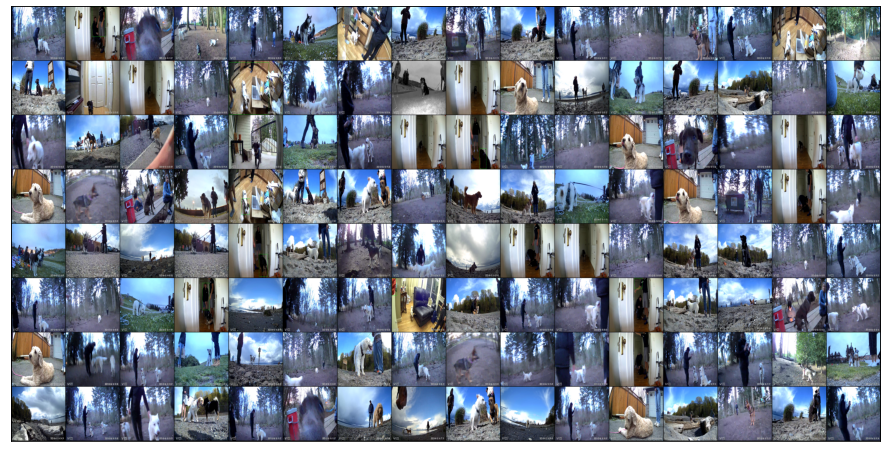

In [ ]:
# show_batch(test_dl)

# Network

Define method to calculate accuracy.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

Set up ResNet 178, 34, and 50

> For WITHOUT class fine tuning: set number of classes to 120

> For WITH class fine tuning: set number of classes to 25

In [ ]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),   # CHANGE to 25 or 120
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_resnet34 = DogBreedPretrainedResnet34()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),   # CHANGE to 25 or 120
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_resnet18 = DogBreedPretrainedResnet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class DogBreedPretrainedResnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),   # CHANGE to 25 or 120
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_resnet50 = DogBreedPretrainedResnet50()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# Getting default device
device = get_default_device()
print(device)

# Moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# Moving model to gpu
to_device(model_resnet50, device);
to_device(model_resnet18, device);
to_device(model_resnet34, device);

cuda


In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

#Training

For each run in the experiment, change the model size accordingly (ResNet18, 34, or 50).

In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model_resnet18(imgs)   # CHANGE model here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 256, 256])
labels :  tensor([ 84,  69,  21,  96,  59, 110, 101,  18, 107,  88, 102,  75,  66,  30,
         19,  48,  98, 103, 105,  18,  83,  38,  87, 102,  46,  24,   8,  79,
        108, 118,  66,  10, 100,  25,  25,  79,  19,  99,  87, 107, 103,  99,
         63,  69,  43,  44,  28, 103,  96, 106,  61, 118,  43,  75, 105,  28,
         69,  47,  51,  25, 107,  53,  52,  62], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-5.8305, -5.4869, -3.6116,  ..., -3.8969, -5.1108, -4.4577],
        [-6.1634, -5.8138, -4.2906,  ..., -4.7607, -5.2911, -5.8151],
        [-5.3955, -5.8510, -4.4732,  ..., -4.3848, -4.7649, -5.8472],
        ...,
        [-5.2618, -6.2602, -4.5313,  ..., -4.2007, -5.2880, -4.9729],
        [-5.6166, -6.0749, -3.9440,  ..., -4.1163, -4.6260, -4.7489],
        [-6.2883, -5.3646, -4.2340,  ..., -4.7699, -5.4594, -5.2477]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

For each run in the experiment, change the model size accordingly (ResNet18, 34, or 50) before evaluating.

In [ ]:
evaluate(model_resnet50, val_dl)   # CHANGE model here

{'val_acc': 0.011029412038624287, 'val_loss': 4.835821628570557}

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
import time
start_time = time.time()

# CHANGE 3rd parameter to match model
history_model_resnet = fit_one_cycle(num_epochs, max_lr, model_resnet50, train_dl, val_dl, weight_decay, grad_clip, opt_func)

train_time = time.time() - start_time

  0%|          | 0/290 [00:00<?, ?it/s]

Epoch [0] : train_loss: 2.4100, val_loss: 0.8993, val_acc: 0.7413


  0%|          | 0/290 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.6198, val_loss: 0.9910, val_acc: 0.6901


  0%|          | 0/290 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.3151, val_loss: 0.8358, val_acc: 0.7451


  0%|          | 0/290 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.1281, val_loss: 0.4982, val_acc: 0.8449


  0%|          | 0/290 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.0490, val_loss: 0.4866, val_acc: 0.8462


In [ ]:
weights_fname = 'dog_classification_resnet.pth'
torch.save(model_resnet50.state_dict(), weights_fname)    # CHANGE model accordingly

# Plots

In [ ]:
history_model_resnet[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
def plot_scores(history):
    scores = [x['val_acc'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs')
    plt.show()
    plt.savefig("Resnet_scores")

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()
    plt.savefig("Loss_resnet")

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')
    plt.show()
    plt.savefig("lrs_resnet")

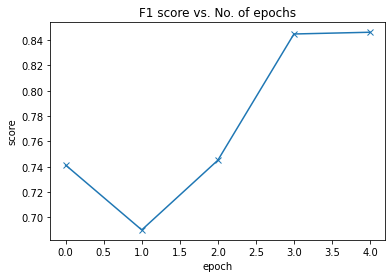

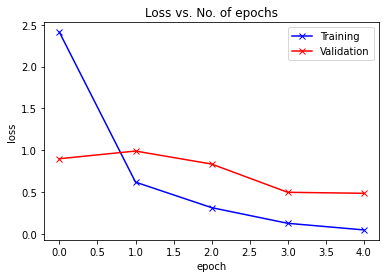

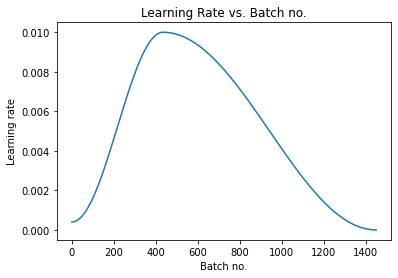

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_scores(history_model_resnet)
plot_losses(history_model_resnet)
plot_lrs(history_model_resnet)

# Test set metrics on Stanford dog set

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

Change model accordingly to the experiment run.

In [ ]:
test_result = evaluate(model_resnet50, test_dl)   # CHANGE model accordingly
print("Test set Accuracy and Loss\n", test_result)

Test set Accuracy and Loss
 {'val_loss': 6.373652935028076, 'val_acc': 0.0167410708963871}


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            #print(y)
            scores = model(x)
            #print(scores)
            
            probabilities = torch.nn.functional.softmax(scores[0], dim=0)
            top1_prob, top1_catid = torch.topk(probabilities, 1)

            _, predictions = scores.max(1)
            
            #confidence score
            probabilities = torch.nn.functional.softmax(scores[0], dim=0)
            top1_prob, top1_catid = torch.topk(probabilities, 1)
            confidence = top1_prob[0].item()
            #print("Predicted:  , with Confidence Score: ", scores, confidence)
            actual_label = dog_labels_train
            #print("Ground truth:",y)
            #print("Predicted is:",scores)
            #print(top1_catid[0])
            #f1 = f1_score(actual_label, predictions)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            print()
    print(f'Got {num_correct} / {num_samples}, Testing Accuracy :  {float(num_correct)/float(num_samples)*100:.2f}') 
    return predictions,confidence

In [ ]:
check_accuracy(test_dl, model_resnet50)   # CHANGE model accordingly








Got 15 / 829, Testing Accuracy :  1.81


(tensor([ 20,  99,  97,  84,  46, 112,  99,  86,  84, 106,   7,  21, 105,  61,
          46, 112, 118, 105,  97,  51,  99, 112, 116,  95, 102,  87,  99,  97,
          46, 105, 112,  97,  99,  57, 105,  52,  99,  73,  18,  29, 112, 104,
          86,  85,  97, 104,  53, 105,  71,  71, 105,  99,  99,  84,  91, 104,
          95,  89,  46,  97,   7], device='cuda:0'), 0.5067933201789856)

In [ ]:
weights_fname = 'dog_stanfordDogs.pth'
torch.save(model_resnet50.state_dict(), weights_fname)    # CHANGE model accordingly

#Test image predictions

In [ ]:
len(dog_labels_train)

25

In [ ]:
def predict_single(test_loader):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model_resnet50(xb)    # CHANGE model accordingly
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', dog_labels_train[label], ' | Predicted :', dog_labels_train[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

Actual : Pembroke  | Predicted : German shepherd


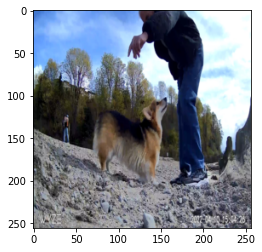

In [ ]:
predict_single(test_dataset[10])
